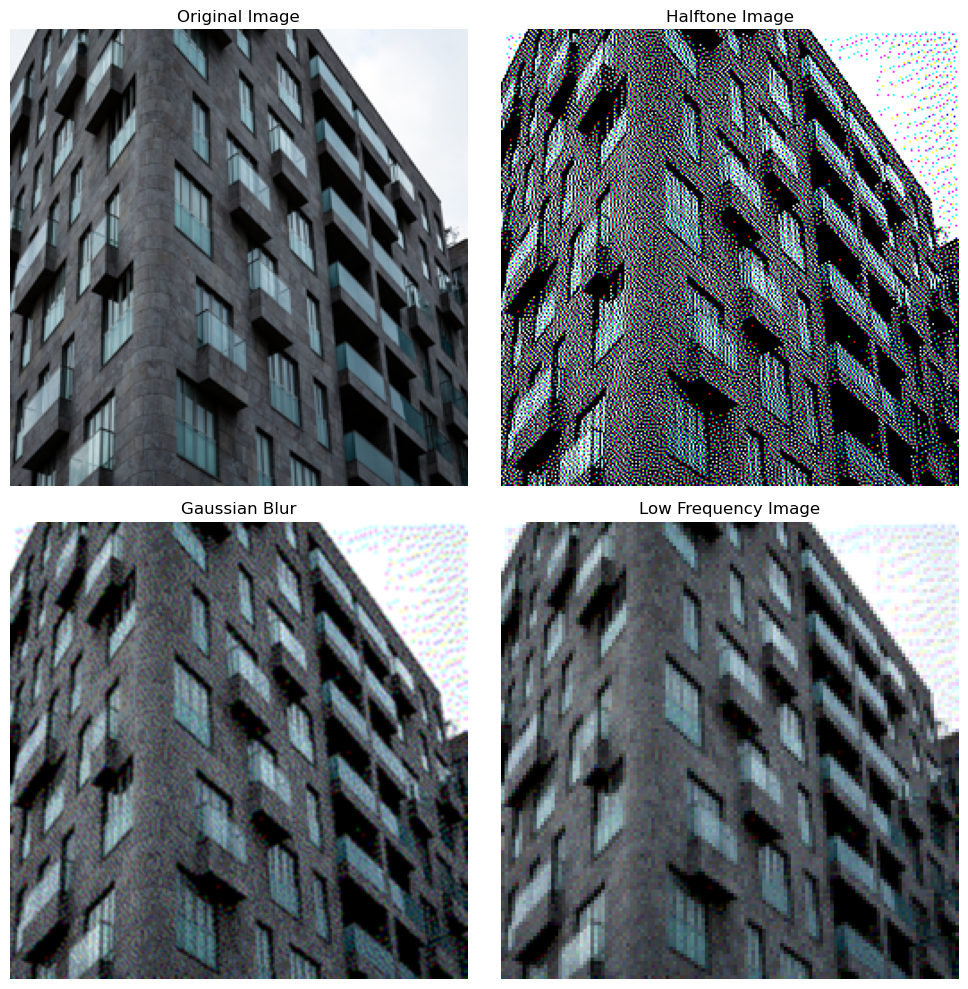

In [12]:
import pywt
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def remove_high_freq(img, wavelet='haar', level=1):
    # 分离RGB通道
    b, g, r = cv2.split(img)
    channels = []
    
    # 对每个通道进行DWT处理
    for c in [b, g, r]:
        coeffs = pywt.wavedec2(c, wavelet, level=level)
        
        # 将高频系数置零
        coeffs_H = list(coeffs)
        coeffs_H[1:] = [(np.zeros_like(cH), np.zeros_like(cV), np.zeros_like(cD)) 
                        for cH, cV, cD in coeffs_H[1:]]
        
        # 重构图像
        reconstructed = pywt.waverec2(coeffs_H, wavelet)
        reconstructed = np.clip(reconstructed, 0, 255).astype(np.uint8)
        channels.append(reconstructed)
    
    # 合并通道
    img_reconstructed = cv2.merge(channels)
    return img_reconstructed

def halftone(img):
    # 分离并处理RGB通道
    b, g, r = cv2.split(img)
    b_ht = np.array(Image.fromarray(b).convert('1').convert('L'))
    g_ht = np.array(Image.fromarray(g).convert('1').convert('L'))  
    r_ht = np.array(Image.fromarray(r).convert('1').convert('L'))
    
    # 合并处理后的通道
    img_ht = cv2.merge([b_ht, g_ht, r_ht])
    return img_ht

def weightedSobel(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_sobel_x = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    img_sobel_y = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

    img_sobel_x = cv2.convertScaleAbs(img_sobel_x)
    img_sobel_y = cv2.convertScaleAbs(img_sobel_y)
    img_sobel = cv2.addWeighted(img_sobel_x, 0.5, img_sobel_y, 0.5, 0)
    return img_sobel
# 主处理流程
img_path = '/home/shenss/python/dataset/Urban100/gt/img_001.png'

# 读取和处理图像
img = np.array(Image.open(img_path))
img_wsobel = weightedSobel(img)
img_ht = halftone(img)
img_gauss = cv2.GaussianBlur(img_ht, (3, 3), 0)
img_low_freq = remove_high_freq(img_gauss, wavelet='haar', level=1)

# 显示结果 - 修改为2x2布局
plt.figure(figsize=(10, 10))
titles = ['Original Image', 'Halftone Image', 'Gaussian Blur', 'Low Frequency Image']
images = [img, img_ht, img_gauss, img_low_freq]

for i, (title, image) in enumerate(zip(titles, images)):
    plt.subplot(2, 2, i+1)
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

plt.tight_layout()
plt.show()